In [2]:
import os
import random
from shutil import copyfile


import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_v3 import InceptionV3

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import itertools

%matplotlib inline
%reload_ext lab_black

In [3]:
local_weight_file = (
    "pretrained_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
)

In [4]:
TARGET_IMAGE_SIZE = 150

In [5]:
pre_trained_model = InceptionV3(
    input_shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 3),
    include_top=False,
    weights=None,
)

In [6]:
pre_trained_model.load_weights(local_weight_file)

In [12]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [27]:
last_layer = pre_trained_model.get_layer("mixed7")

In [28]:
last_layer.output_shape

(None, 7, 7, 768)

In [29]:
last_layer.output

<tf.Tensor 'mixed7/Identity:0' shape=(None, 7, 7, 768) dtype=float32>

In [39]:
def create_model_with_transfer_learning():

    output_layer = keras.layers.Flatten()(last_layer.output)

    output_layer = keras.layers.Dense(units=1024, activation="relu")(output_layer)

    output_layer = keras.layers.Dropout(rate=0.2)(output_layer)

    output_layer = keras.layers.Dense(units=1, activation="sigmoid")(output_layer)

    model = keras.Model(inputs=pre_trained_model.input, outputs=output_layer)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

## Prepare Dataset

In [34]:
TRAIN_DATASET_PATH = "../week_1/full_dataset/cats-v-dogs/training/"
VALIDATION_DATASET_PATH = "../week_1/full_dataset/cats-v-dogs/testing/"

BATCH_SIZE = 32

In [35]:
augmentation_args = {
    "rotation_range": 40,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.2,
    "zoom_range": 0.2,
    "horizontal_flip": True,
    "fill_mode": "nearest",
}

In [37]:
train_data_gen = ImageDataGenerator(rescale=1.0 / 255, **augmentation_args)

train_generator = train_data_gen.flow_from_directory(
    TRAIN_DATASET_PATH,
    batch_size=BATCH_SIZE,
    target_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
    class_mode="binary",
)

validation_data_gen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_data_gen.flow_from_directory(
    VALIDATION_DATASET_PATH,
    batch_size=BATCH_SIZE,
    target_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
    class_mode="binary",
)

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [44]:
transfer_model = create_model_with_transfer_learning()

In [45]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy')

In [46]:
history_transfer = transfer_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 85 steps, validate for 10 steps
Epoch 1/15
85/85 [==============================] - 38s 443ms/step - loss: 0.5792 - accuracy: 0.7904 - val_loss: 0.1823 - val_accuracy: 0.9367
Epoch 2/15
85/85 [==============================] - 38s 449ms/step - loss: 0.3420 - accuracy: 0.8552 - val_loss: 0.1154 - val_accuracy: 0.9567
Epoch 3/15
85/85 [==============================] - 39s 459ms/step - loss: 0.3184 - accuracy: 0.8633 - val_loss: 0.1596 - val_accuracy: 0.9533
Epoch 4/15
85/85 [==============================] - 40s 472ms/step - loss: 0.2968 - accuracy: 0.8704 - val_loss: 0.0935 - val_accuracy: 0.9633
Epoch 5/15
85/85 [==============================] - 38s 449ms/step - loss: 0.2736 - accuracy: 0.8789 - val_loss: 0.2326 - val_accuracy: 0.9567
Epoch 6/15
85/85 [==============================] - 40s 471ms/step - loss: 0.2626 - accuracy: 0.8896 - val_loss: 0.0992 - val_accuracy: 0.9667
Epoch 7/15
85/85 [==============================] 

Text(0.5, 1.0, 'Loss Train vs Validation')

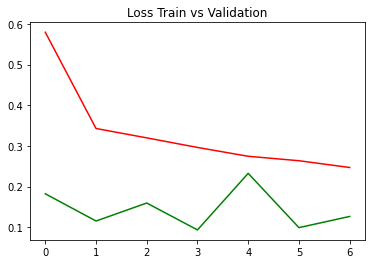

In [47]:
plt.plot(
    history_transfer.epoch, history_transfer.history["loss"], "r-", label="Training"
)
plt.plot(
    history_transfer.epoch,
    history_transfer.history["val_loss"],
    "g-",
    label="Validation",
)

plt.title("Loss Train vs Validation")

Text(0.5, 1.0, 'Accuracy Train vs Validation')

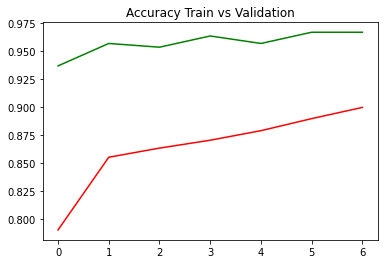

In [48]:
plt.plot(history_transfer.epoch, history_transfer.history["accuracy"], color="r")
plt.plot(history_transfer.epoch, history_transfer.history["val_accuracy"], color="g")

plt.title("Accuracy Train vs Validation")